## Modelling

This note book explains the different steps in the machine learning model.For the trigger model we used a Regression model. First the model is trained on the full dataset to obtain the optimal features followed by hyper parameter tunning and model performance estimate using Nested Cross Validation.

* Nested Cross Validation for
    * Feature selection 
    * hyper parameter tunning 
* Performance metrics
* Baseline Models
 
### Regression 
At the end of this section we will obtain  the optimal Regression models and the performance estimates. Two models are implemented: Random Forest, XGBoost.First, the model is trained on the full dataset to obtain the optimal features followed by a model that obtains the performance estimate using Nested Cross Validation.

In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
import random
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import os
from sklearn.feature_selection import RFECV
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error
import numpy as np
from numpy.lib.function_base import average
import pandas as pd
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import importlib
import os
from sklearn.feature_selection import (
    SelectKBest,
    RFE,
    mutual_info_regression,
    f_regression,
    mutual_info_classif,
)
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import xgboost as xgb
import random
import pickle
import openpyxl
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import pickle
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import random
import importlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define functions 

In [52]:
def splitting_train_test(df):

    # To save the train and test sets
    df_train_list = []
    df_test_list = []

    # List of typhoons that are to be used as a test set 
 
    typhoons_with_impact_data=list(np.unique(df.typhoon))

    for typhoon in typhoons_with_impact_data:
        if len(df[df["typhoon"] == typhoon]) >1:
            df_train_list.append(df[df["typhoon"] != typhoon])
            df_test_list.append(df[df["typhoon"] == typhoon])

    return df_train_list, df_test_list


def unweighted_random(y_train, y_test):
    options = y_train.value_counts(normalize=True)
    y_pred = random.choices(population=list(options.index), k=len(y_test))
    return y_pred

def weighted_random(y_train, y_test):
    options = y_train.value_counts()
    y_pred = random.choices(
        population=list(options.index), weights=list(options.values), k=len(y_test)
    )
    return y_pred

In [425]:
# Setting directory

wor_dir="/home/fbf/"
os.chdir(wor_dir)

cdir = os.getcwd()

In [23]:
wor_dir="C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-Typhoon-model\\"
os.chdir(wor_dir)
cdir = os.getcwd()

In [24]:
# Import functions
from models.regression.rf_regression import (rf_regression_features,rf_regression_performance,)
from models.regression.xgb_regression import (xgb_regression_features,xgb_regression_performance,)


## Loading the data

In [29]:
combined_input_data=pd.read_csv("data/model_input/combined_input_data.csv")

typhoons_with_impact_data=['bopha2012', 'conson2010', 'durian2006', 'fengshen2008',
       'fung-wong2014', 'goni2015', 'goni2020', 'hagupit2014',
       'haima2016', 'haiyan2013', 'jangmi2014', 'kalmaegi2014',
       'kammuri2019', 'ketsana2009', 'koppu2015', 'krosa2013',
       'linfa2015', 'lingling2014', 'mangkhut2018', 'mekkhala2015',
       'melor2015', 'meranti2016', 'molave2020', 'mujigae2015',
       'nakri2019', 'nari2013', 'nesat2011', 'nock-ten2016', 'noul2015',
       'phanfone2019', 'rammasun2014', 'sarika2016', 'saudel2020',
       'tokage2016', 'trami2013', 'usagi2013', 'utor2013', 'vamco2020',
       'vongfong2020', 'yutu2018']

len(np.unique(combined_input_data.typhoon))


40

In [26]:
len(typhoons_with_impact_data)

40

In [ ]:
combined_input_data=combined_input_data[combined_input_data.typhoon.isin(typhoons_with_impact_data)]

Replace missing values with zero for records with low windspeed and rainfall \n

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mfrac>
    <msup>
      <mi>V</mi>
      <mn>2</mn>
    </msup>
    <mrow>
      <mo stretchy="false">(</mo>
      <mn>V_max</mn>
      <msup>
        <mo stretchy="false">)</mo>
        <mn>2</mn>
      </msup>
    </mrow>
  </mfrac>
  <mo>+</mo>
  <mfrac>
    <msup>
      <mi>rain</mi>
      <mn>2</mn>
    </msup>
    <mrow>
      <mo stretchy="false">(</mo>
      <mn>rain_max</mn>
      <msup>
        <mo stretchy="false">)</mo>
        <mn>2</mn>
      </msup>
    </mrow>
  </mfrac>
  <mo>=</mo>
  <mn>1</mn>
</math>

In [30]:
def set_zeros(x):
    x_max = 25
    y_max = 50
    
    v_max = x[0]
    rainfall_max = x[1]
    damage = x[2]
    if pd.notnull(damage):
        value = damage
    elif v_max > x_max or rainfall_max > y_max:
        value =damage
    elif (v_max < np.sqrt((1- (rainfall_max**2/y_max ** 2))*x_max ** 2)):
        value = 0
    #elif ((v_max < x_max)  and  (rainfall_max_6h < y_max) ):
    #elif (v_max < x_max ):
    #value = 0
    else:
        value = np.nan

    return value
combined_input_data["DAM_perc_dmg"] = combined_input_data[["HAZ_v_max", "HAZ_rainfall_Total", "DAM_perc_dmg"]].apply(set_zeros, axis="columns")

In [56]:
len(combined_input_data)

8073

In [32]:
np.mean(combined_input_data["DAM_perc_dmg"])

2.455842692294789

In [33]:
combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
np.mean(combined_input_data["DAM_perc_dmg"])

2.455842692294789

In [34]:
len(combined_input_data)

8073

In [42]:
np.unique(combined_input_data.typhoon)

array(['bopha2012', 'conson2010', 'durian2006', 'fengshen2008',
       'fung-wong2014', 'goni2015', 'goni2020', 'hagupit2014',
       'haima2016', 'haiyan2013', 'jangmi2014', 'kalmaegi2014',
       'kammuri2019', 'ketsana2009', 'koppu2015', 'krosa2013',
       'linfa2015', 'lingling2014', 'mangkhut2018', 'mekkhala2015',
       'melor2015', 'meranti2016', 'molave2020', 'mujigae2015',
       'nakri2019', 'nari2013', 'nesat2011', 'nock-ten2016', 'noul2015',
       'phanfone2019', 'rammasun2014', 'sarika2016', 'saudel2020',
       'tokage2016', 'usagi2013', 'utor2013', 'vamco2020', 'vongfong2020',
       'yutu2018'], dtype=object)

### Adtional variables 

In [43]:
def cubeic(x):
    #x=float(x)
    value=x*x*x
    return value


#combined_input_data["HAZ_v_max_3"] = combined_input_data.apply(lambda x: cubeic(x["HAZ_v_max"]), axis=1).values

combined_input_data['HAZ_v_max_3']=combined_input_data['HAZ_v_max'].apply(lambda x: x*x*x) 

In [44]:
combined_input_data =combined_input_data.filter(['typhoon','HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary', 
        'DAM_perc_dmg'])

In [45]:
features =['HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary']

#### Random Forest 

In [57]:
# Full dataset for feature selection

df=combined_input_data.dropna()
 
#combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
X = df[features]
y = df["DAM_perc_dmg"]

# Setting the train and the test sets for obtaining performance estimate
df_train_list, df_test_list = splitting_train_test(df)

### Feature selection

Feature Selection is an important step in devloping a machine learning model.Data features used to train a machine learning model will influence model performance,less important features can have a negative impact on model performance.
Feature Selection aims to solve the problem of identifying relevant features from a dataset by removing the less important features, which have little/no contribution to our target variable. Feature selection helps to achieve better model accuracy.

There are different techniques for feature selection. For this research we used Recursive feature elimination (RFE),which is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s coef_ or feature_importances_ attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in the model.
To find the optimal number of features we applied cross-validation with RFE on the entire data set. 


In [ ]:
#%% Setting input varialbes
rf_search_space = [
    {
        "estimator__n_estimators": [100, 150],
        "estimator__max_depth": [20, None],
        "estimator__min_samples_split": [4, 5, 8],
        "estimator__min_samples_leaf":[1, 3, 5],
    }
]

(
    selected_features_rf_regr,
    selected_params_rf_regr_full,
) = rf_regression_features(
    X=X,
    y=y,
    features=features,
    search_space=rf_search_space,
    min_features_to_select=1,
    cv_splits=3,
    GS_score="neg_root_mean_squared_error",
    GS_randomized=False,
    GS_n_iter=10,
    verbose=10,
)

print(
    f"Number of selected features RF Regression {len(selected_features_rf_regr)}"
)
print(f"Selected features RF Regression: {selected_features_rf_regr}")
print(f"Selected Parameters RF Regression: {selected_params_rf_regr_full}")

In [63]:
# Based on output previous cell
selected_features_rf_regr=[
    'HAZ_rainfall_Total', 
    'HAZ_rainfall_max_6h',
    'HAZ_rainfall_max_24h',
    'HAZ_v_max', 
    'HAZ_v_max_3',
    'HAZ_dis_track_min',
    'GEN_landslide_per', 
    'GEN_stormsurge_per',
    'GEN_Bu_p_inSSA', 
    'GEN_Bu_p_LS',
    'GEN_Red_per_LSbldg',
    'GEN_Yel_per_LSSAb',
    'GEN_RED_per_SSAbldg', 
    'GEN_OR_per_SSAbldg',
    'TOP_mean_slope', 
    'TOP_mean_elevation_m', 
    'TOP_ruggedness_stdev', 
    'TOP_mean_ruggedness', 
    'TOP_slope_stdev', 
    'VUL_poverty_perc', 
    'GEN_coast_length',
    'VUL_Housing_Units', 
    'VUL_StrongRoof_StrongWall', 
    'VUL_StrongRoof_LightWall',
    'VUL_StrongRoof_SalvageWall',
    'VUL_LightRoof_LightWall', 
    'VUL_LightRoof_SalvageWall', 
    'VUL_SalvagedRoof_StrongWall',
    'VUL_SalvagedRoof_LightWall', 
    'VUL_SalvagedRoof_SalvageWall',
    'VUL_vulnerable_groups', 
    'VUL_pantawid_pamilya_beneficiary'
]

In [ ]:
#xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
#xgb.plot_importance(xg_reg)
#plt.rcParams['figure.figsize'] = [5, 5]
#plt.show()

### Hyper Parameter optimization  

Machine learning models have hyperparameters that you must set in order to customize the model to your dataset. Often the general effects of hyperparameters on a model are known, but how to best set a hyperparameter and combinations of interacting hyperparameters for a given dataset is challenging. There are often general rules of thumb for configuring hyperparameters. A better approach is to objectively search different values for model hyperparameters and choose a subset that results in a model that achieves the best performance on a given dataset. This is called hyperparameter optimization or hyperparameter tuning and is available in the scikit-learn Python machine learning library. [Source](https://machinelearningmastery.com/) 




Hyperparameters are essentila components for machine learning algorithms, they control behaviour and performance of a machine learning model. For a learning algorithm optimal hyperparameter selection, hyperparameter tuning is esstil first step as it helps to achive best model performance on the data set with a reasonable amount of time.[source](https://www.sciencedirect.com/science/article/pii/S1674862X19300047)

To reduce the bias in performance evaluation, model selection should be treated as an integral part of the model fitting procedure, and should be conducted independently in each trial in order to prevent selection bias.[source](https://www.jmlr.org/papers/v11/cawley10a.html)

There are different techniques for Hyperparameters, for this research we used neasted K-fold cross validation technique. 
Nested cross-validation uses inner and outer loops when optimizing the hyperparameters of a model on a dataset, and when comparing and selecting a model for the dataset. This reduced biased evaluation of model performance as different dataset are used to for hyperparameter tunning and model selection.

In our implementation of nested CV the outer loop iterates over typhoon events in our datasets, holiding data for one typhoon for test set and assigning the remaining data as training set. In the inner loop a k-fold CV is applied on the training dataset



In [58]:
#%% Setting input varialbes
rf_search_space = [
    {
        "rf__n_estimators": [200],
        "rf__max_depth": [18],
        "rf__min_samples_split": [8],
        "rf__min_samples_leaf": [1],
    }
]

df_predicted_rf_regr, selected_params_rf_regr = rf_regression_performance(
    df_train_list=df_train_list,
    df_test_list=df_test_list,
    y_var='DAM_perc_dmg',
    features=selected_features_rf_regr,#selected_features_rf_regr,
    search_space=rf_search_space,
    cv_splits=4,
    GS_score="neg_root_mean_squared_error",
    GS_randomized=False,
    GS_n_iter=10,
    verbose=10,
)

Running for 1 out of a total of 39
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 1/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-2.913, test=-5.593) total time=  15.8s
[CV 2/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 2/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-2.977, test=-6.126) total time=  16.0s
[CV 3/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 3/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-2.974, test=-5.726) total time=  16.0s
[CV 4/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estima

[CV 1/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-3.016, test=-5.813) total time=  17.9s
[CV 2/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 2/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-3.039, test=-6.010) total time=  17.3s
[CV 3/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 3/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-3.109, test=-5.398) total time=  17.3s
[CV 4/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 4/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-2.929, test=-6.286) total time=  17.6s
Selected Parameters {'rf__max_de

[CV 2/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-2.953, test=-6.009) total time=  17.3s
[CV 3/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 3/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-2.946, test=-5.712) total time=  17.1s
[CV 4/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 4/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-3.077, test=-5.728) total time=  16.3s
Selected Parameters {'rf__max_depth': 18, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 8, 'rf__n_estimators': 200}
Train score: 0.9181701199789473
Test score: 3.05935615573451
Running for 14 out of a total of 39
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4; 1/1] START rf_

[CV 3/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-3.044, test=-6.147) total time=  17.2s
[CV 4/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 4/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-3.044, test=-6.257) total time=  18.1s
Selected Parameters {'rf__max_depth': 18, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 8, 'rf__n_estimators': 200}
Train score: 0.9723055980008027
Test score: 2.7259798660969947
Running for 20 out of a total of 39
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 1/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-2.987, test=-5.806) total time=  18.2s
[CV 2/4; 1/1] START r

[CV 4/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-2.973, test=-6.011) total time=  19.1s
Selected Parameters {'rf__max_depth': 18, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 8, 'rf__n_estimators': 200}
Train score: 0.9418125499841419
Test score: 1.9789539852234285e-07
Running for 26 out of a total of 39
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 1/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-3.015, test=-6.026) total time=  20.2s
[CV 2/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 2/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-3.044, test=-5.626) total time=  19.1s
[CV 3/4; 1/1] STA

Selected Parameters {'rf__max_depth': 18, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 8, 'rf__n_estimators': 200}
Train score: 0.9170649328298324
Test score: 4.701097084135209
Running for 32 out of a total of 39
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 1/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-2.967, test=-5.913) total time=  20.1s
[CV 2/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 2/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-2.958, test=-6.314) total time=  20.2s
[CV 3/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 3/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples

[CV 1/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-3.060, test=-6.085) total time=  18.2s
[CV 2/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 2/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-3.005, test=-5.503) total time=  19.6s
[CV 3/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 3/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-3.028, test=-6.067) total time=  19.2s
[CV 4/4; 1/1] START rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200
[CV 4/4; 1/1] END rf__max_depth=18, rf__min_samples_leaf=1, rf__min_samples_split=8, rf__n_estimators=200;, score=(train=-3.080, test=-5.915) total time=  18.8s
Selected Parameters {'rf__max_de

In [59]:
#Selected_Parameters={'rf__max_depth': 22, 
# 'rf__min_samples_leaf': 3,
# 'rf__min_samples_split': 2,
# 'rf__n_estimators': 100}

#rf__max_depth': 18,
#'rf__min_samples_leaf': 1,
#'rf__min_samples_split': 8,
#'rf__n_estimators': 200

 


file_name = "models/output/v1/selected_params_rf_regr1.p"
path = os.path.join(cdir, file_name)
pickle.dump(selected_params_rf_regr, open(path, "wb"))

file_name = "models/output/v1/df_predicted_rf_regr1.csv"
path = os.path.join(cdir, file_name)
df_predicted_rf_regr.to_csv(path)

#df_predicted_rf_regr=pd.read_csv(path)

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_23440/3092513733.py:16: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-Typhoon-model\\models/output/v1/selected_params_rf_regr1.p'>
  pickle.dump(selected_params_rf_regr, open(path, "wb"))


In [60]:
df_predicted_rf_regr

typhoon    actual     predicted
1925   bopha2012  0.000000  3.103131e-03
1927   bopha2012  0.000000  0.000000e+00
1928   bopha2012  0.000000  0.000000e+00
1929   bopha2012  0.000000  4.978486e-02
1930   bopha2012  0.000000  9.195151e-04
...          ...       ...           ...
24605   yutu2018  0.000000  0.000000e+00
24613   yutu2018  0.000000  3.853367e-07
24617   yutu2018  0.000000  3.853367e-07
24619   yutu2018  0.247804  1.191573e+00
24622   yutu2018  0.000000  3.853367e-07

[8073 rows x 3 columns]

In [ ]:
##combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()] 

### XGBoost Regression 
Obtaining the optimal model

In [61]:
# Full dataset for feature selection



combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]

X = combined_input_data[features]
y = combined_input_data["DAM_perc_dmg"]

# Setting the train and the test sets for obtaining performance estimate
df_train_list, df_test_list = splitting_train_test(combined_input_data)


 

In [ ]:
#learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
#max_depth: determines how deeply each tree is allowed to grow during any boosting round.
#subsample: percentage of samples used per tree. Low value can lead to underfitting.
#colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
#n_estimators: number of trees you want to build.

xgb_search_space = [
    {
        "estimator__learning_rate": [0.1, 0.5, 1],
        "estimator__gamma": [0.1, 0.5, 2],
        "estimator__max_depth": [6, 8],
        "estimator__reg_lambda": [0.001, 0.1, 1],
        "estimator__n_estimators": [100, 150,200],
        "estimator__colsample_bytree": [0.5, 0.7],
    }
]

selected_features_xgb_regr, selected_params_xgb_regr_full = xgb_regression_features(
    X=X,
    y=y,
    features=features,
    search_space=xgb_search_space,
    min_features_to_select=1,
    cv_splits=5,
    GS_score="neg_root_mean_squared_error",
    objective="reg:squarederror",
    GS_randomized=True,
    GS_n_iter=400,
    verbose=10,
)


print(f"Number of selected features XGBoost Regression {len(selected_features_xgb_regr)}")
print(f"Selected features XGBoost Regression: {selected_features_xgb_regr}")
print(f"Selected Parameters XGBoost Regression: {selected_params_xgb_regr_full}")



### Obtaining performance estimate

In [77]:
# Setting the selected features for XGB based on the above cell


selected_features_xgb_regr =['HAZ_rainfall_Total',
 'HAZ_v_max',
 'HAZ_dis_track_min',
 'GEN_landslide_per',
 'TOP_mean_elevation_m',
 'TOP_mean_ruggedness',
 'VUL_Housing_Units',
 'VUL_StrongRoof_StrongWall',
 'VUL_StrongRoof_LightWall',
 'VUL_LightRoof_StrongWall',
 'VUL_vulnerable_groups',
 'VUL_pantawid_pamilya_beneficiary']

#selected_features_xgb_regr =selected_features_rf_regr
selected_params_xgb_regr_full={'estimator__reg_lambda': 0.001,
 'estimator__n_estimators': 200,
 'estimator__max_depth': 6,
 'estimator__learning_rate': 0.1,
 'estimator__gamma': 0.1,
 'estimator__colsample_bytree': 0.5}

### parameter optimization first based on selected model features

In [78]:
xgb_search_space = [
    {
        "xgb__learning_rate": [0.03],
        "xgb__gamma": [0.1],
        "xgb__max_depth": [6,8],
        "xgb__reg_lambda": [0.001],
        "xgb__n_estimators": [50],
        "xgb__colsample_bytree": [0.7],
    }
]



df_predicted_xgb_regr, selected_params_xgb_regr = xgb_regression_performance(
    df_train_list=df_train_list,
    df_test_list=df_test_list,
    y_var='DAM_perc_dmg',
    features=features,#selected_features_xgb_regr,
    search_space=xgb_search_space,
    cv_splits=5,
    objective="reg:squarederror",
    GS_score="neg_root_mean_squared_error",
    GS_randomized=True,
    GS_n_iter=500,
    verbose=10,
)


Running for 1 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.526, test=-5.670) total time=   0.2s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.392, test=-6.502) total time=   0.2s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.690, test=-5.422) total time=   0.2s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.513, test=-7.169) total time=   0.2s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.588, test=-5.660) total time=   0.2s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.605, test=-5.643) total time=   0.3s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.416, test=-6.439) total time=   0.4s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.658, test=-5.502) total time=   0.3s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.602, test=-6.945) total time=   0.3s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.550, test=-5.772) total time=   0.3s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.358632646390158
Test score: 2.082504046908738
Running for 2 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.634, test=-5.982) total time=   0.2s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.826, test=-5.678) total time=   0.2s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.700, test=-6.403) total time=   0.2s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.455, test=-7.366) total time=   0.2s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.942, test=-5.162) total time=   0.2s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.613, test=-6.058) total time=   0.4s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.751, test=-5.529) total time=   0.4s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.718, test=-6.563) total time=   0.4s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.455, test=-7.163) total time=   0.3s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.938, test=-5.068) total time=   0.3s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.369054437059842
Test score: 0.66940614032334
Running for 3 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.397, test=-6.143) total time=   0.2s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.285, test=-5.869) total time=   0.2s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.224, test=-6.255) total time=   0.2s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.469, test=-4.988) total time=   0.2s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.384, test=-6.465) total time=   0.2s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.524, test=-6.212) total time=   0.3s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.387, test=-5.610) total time=   0.4s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.254, test=-6.164) total time=   0.4s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.519, test=-4.858) total time=   0.4s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.480, test=-6.356) total time=   0.4s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.2810843925545135
Test score: 4.140316876612458
Running for 4 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.590, test=-5.895) total time=   0.2s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.391, test=-6.133) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.748, test=-5.513) total time=   0.2s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.546, test=-5.588) total time=   0.2s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.349, test=-7.140) total time=   0.2s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.577, test=-5.698) total time=   0.4s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.412, test=-6.173) total time=   0.4s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.754, test=-5.452) total time=   0.4s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.534, test=-5.483) total time=   0.4s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.421, test=-7.055) total time=   0.4s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3007988323863975
Test score: 2.3364479443737354
Running for 5 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.798, test=-6.128) total time=   0.2s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.753, test=-5.437) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.633, test=-6.568) total time=   0.2s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.650, test=-6.615) total time=   0.2s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.653, test=-5.987) total time=   0.2s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.802, test=-6.093) total time=   0.4s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.740, test=-5.424) total time=   0.4s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.635, test=-6.484) total time=   0.4s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.674, test=-6.583) total time=   0.4s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.667, test=-5.861) total time=   0.4s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3719804462967766
Test score: 0.8046452023620717
Running for 6 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.737, test=-5.823) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.608, test=-6.290) total time=   0.2s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.581, test=-7.011) total time=   0.2s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.668, test=-6.068) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.752, test=-5.839) total time=   0.2s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.832, test=-5.759) total time=   0.4s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.659, test=-6.092) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.595, test=-6.939) total time=   0.4s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.685, test=-5.976) total time=   0.4s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.743, test=-5.687) total time=   0.4s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.36390757192682
Test score: 1.0952915605410927
Running for 7 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.818, test=-5.771) total time=   0.2s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.676, test=-6.617) total time=   0.2s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.560, test=-6.241) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.588, test=-6.412) total time=   0.2s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.626, test=-5.730) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.782, test=-5.779) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.695, test=-6.462) total time=   0.4s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.569, test=-6.228) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.558, test=-6.278) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.598, test=-5.605) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3389467821794057
Test score: 1.8679594035356781
Running for 8 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.495, test=-6.710) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.740, test=-5.848) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.610, test=-6.693) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.845, test=-5.654) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.702, test=-6.031) total time=   0.2s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.447, test=-6.500) total time=   0.4s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.665, test=-5.850) total time=   0.4s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.726, test=-6.696) total time=   0.4s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.785, test=-5.555) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.677, test=-5.995) total time=   0.4s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3358073816880613
Test score: 2.027941795004597
Running for 9 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.788, test=-5.766) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.568, test=-7.084) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.590, test=-6.348) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.426, test=-6.368) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.849, test=-5.389) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.923, test=-5.640) total time=   0.4s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.658, test=-6.965) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.641, test=-6.313) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.409, test=-6.365) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.893, test=-5.296) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3406639069586181
Test score: 1.7168108066746988
Running for 10 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.732, test=-5.651) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.016, test=-4.949) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.850, test=-5.069) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.917, test=-4.762) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.675, test=-6.182) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-2.804, test=-5.566) total time=   0.6s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.015, test=-4.902) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-2.826, test=-5.079) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-2.976, test=-4.735) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-2.780, test=-6.198) total time=   0.7s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.0319539911534255
Test score: 13.100300098499764
Running for 11 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.810, test=-6.095) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.810, test=-5.074) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.671, test=-6.553) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.676, test=-6.175) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.468, test=-7.016) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.782, test=-6.047) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.802, test=-5.056) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.787, test=-6.676) total time=   0.6s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.692, test=-6.070) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.464, test=-7.002) total time=   0.6s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3804747483286992
Test score: 0.5848816910931948
Running for 12 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.855, test=-5.800) total time=   0.4s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.824, test=-5.732) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.702, test=-6.193) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.426, test=-6.550) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.437, test=-6.561) total time=   0.4s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.831, test=-5.880) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.900, test=-5.764) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.748, test=-6.323) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.483, test=-6.557) total time=   0.6s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.492, test=-6.533) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.6192200486208572
Test score: 1.1407275433505253
Running for 13 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.570, test=-6.870) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.738, test=-5.231) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.632, test=-6.623) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.537, test=-6.382) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.576, test=-6.087) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.577, test=-6.722) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.693, test=-5.192) total time=   0.4s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.578, test=-6.370) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.543, test=-6.340) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.564, test=-6.098) total time=   0.4s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.2967284112808979
Test score: 2.4822053260054933
Running for 14 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.574, test=-6.074) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.563, test=-6.294) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.819, test=-4.782) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.712, test=-6.362) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.396, test=-7.106) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.608, test=-6.076) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.677, test=-6.336) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.807, test=-4.739) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.657, test=-6.306) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.455, test=-7.006) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3590902213488105
Test score: 1.355245599062085
Running for 15 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.707, test=-6.069) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.575, test=-7.008) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.692, test=-6.006) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.693, test=-5.918) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.590, test=-5.918) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.687, test=-6.044) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.519, test=-6.921) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.745, test=-6.030) total time=   0.4s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.782, test=-5.758) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.650, test=-5.925) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3541540679961093
Test score: 2.110864485937909
Running for 16 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.717, test=-5.823) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.744, test=-6.507) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.366, test=-6.995) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.753, test=-5.731) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.894, test=-5.846) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.687, test=-5.824) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.851, test=-6.345) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.391, test=-6.844) total time=   0.6s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.699, test=-5.740) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.896, test=-5.917) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3579202090599622
Test score: 0.7748823126947482
Running for 17 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.638, test=-6.574) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.676, test=-6.439) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.692, test=-6.190) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.542, test=-6.133) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.655, test=-6.093) total time=   0.4s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.669, test=-6.582) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.721, test=-6.392) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.707, test=-6.085) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.605, test=-6.110) total time=   0.6s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.610, test=-6.093) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3647241127415488
Test score: 0.45679260491732376
Running for 18 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.617, test=-6.766) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.689, test=-5.147) total time=   0.4s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.591, test=-6.119) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.725, test=-5.829) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.545, test=-6.997) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.638, test=-6.701) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.691, test=-5.086) total time=   0.6s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.600, test=-6.014) total time=   0.6s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.765, test=-5.741) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.553, test=-6.954) total time=   0.6s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3612429743918841
Test score: 1.0362376467589594
Running for 19 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.728, test=-6.802) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.756, test=-5.938) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.755, test=-6.236) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.688, test=-5.810) total time=   0.4s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.630, test=-6.584) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.841, test=-6.604) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.863, test=-5.944) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.727, test=-6.279) total time=   0.6s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.685, test=-5.778) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.682, test=-6.610) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.380727771713044
Test score: 1.8653690201047803
Running for 20 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.768, test=-5.648) total time=   0.4s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.545, test=-6.667) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.631, test=-6.781) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.915, test=-5.125) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.574, test=-6.704) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.813, test=-5.559) total time=   0.6s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.601, test=-6.610) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.738, test=-6.600) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.897, test=-5.216) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.544, test=-6.785) total time=   0.6s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.4029826208070184
Test score: 0.7911281845935817
Running for 21 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.451, test=-5.724) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.410, test=-6.839) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.497, test=-5.677) total time=   0.4s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.509, test=-5.939) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.526, test=-5.385) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.631, test=-5.673) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.530, test=-6.863) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.547, test=-5.704) total time=   0.6s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.619, test=-5.827) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.622, test=-5.300) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3075971583873895
Test score: 5.716772915789136
Running for 22 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.455, test=-7.574) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.632, test=-5.841) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.769, test=-5.622) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.569, test=-6.273) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.681, test=-5.124) total time=   0.4s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.593, test=-7.494) total time=   0.6s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.687, test=-5.696) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.776, test=-5.529) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.608, test=-6.181) total time=   0.6s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.618, test=-5.117) total time=   0.6s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3560259933492824
Test score: 1.5038342997027336
Running for 23 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.549, test=-6.641) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.803, test=-6.181) total time=   0.4s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.654, test=-5.556) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.711, test=-6.573) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.752, test=-5.533) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.623, test=-6.513) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.858, test=-6.174) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.632, test=-5.458) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.770, test=-6.540) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.671, test=-5.473) total time=   0.6s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.350020692588724
Test score: 1.6907861871318355
Running for 24 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.545, test=-5.804) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.699, test=-5.898) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.850, test=-5.880) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.541, test=-7.001) total time=   0.4s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.728, test=-6.264) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.529, test=-5.828) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.735, test=-5.951) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.866, test=-5.760) total time=   0.6s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.549, test=-6.946) total time=   0.7s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.814, test=-6.295) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3700635075842411
Test score: 0.2341133974695387
Running for 25 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.646, test=-6.575) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.664, test=-5.095) total time=   0.4s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.663, test=-6.664) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.629, test=-5.984) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.604, test=-6.197) total time=   0.4s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.737, test=-6.411) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.653, test=-4.979) total time=   0.6s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.678, test=-6.573) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.654, test=-5.887) total time=   0.6s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.622, test=-6.238) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3579302325715807
Test score: 0.13206444680690765
Running for 26 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.708, test=-6.655) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.807, test=-5.683) total time=   0.4s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.662, test=-6.488) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.539, test=-6.176) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.563, test=-5.856) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.823, test=-6.471) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.733, test=-5.621) total time=   0.6s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.697, test=-6.485) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.543, test=-6.214) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.552, test=-5.873) total time=   0.6s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3546765200592543
Test score: 2.3074726000183285
Running for 27 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.706, test=-5.863) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.508, test=-6.720) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.633, test=-6.648) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.693, test=-6.614) total time=   0.4s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.807, test=-5.545) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.671, test=-5.828) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.571, test=-6.668) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.694, test=-6.623) total time=   0.6s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.739, test=-6.524) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.797, test=-5.485) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3771957169493114
Test score: 1.2825087108741966
Running for 28 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.588, test=-5.841) total time=   0.4s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.557, test=-5.808) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.580, test=-7.083) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.733, test=-5.940) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.594, test=-6.020) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.617, test=-5.724) total time=   0.6s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.543, test=-5.904) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.595, test=-7.010) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.730, test=-5.900) total time=   0.6s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.702, test=-5.927) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3644540103819474
Test score: 1.6238783217424602
Running for 29 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.738, test=-5.588) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.729, test=-6.853) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.780, test=-6.361) total time=   0.4s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.646, test=-6.283) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.794, test=-5.943) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.702, test=-5.526) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.827, test=-6.769) total time=   0.6s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.831, test=-6.216) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.673, test=-6.366) total time=   0.6s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.714, test=-5.939) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.404375739176222
Test score: 0.157559270931276
Running for 30 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.584, test=-5.996) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.789, test=-5.225) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.733, test=-5.288) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.535, test=-6.605) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.436, test=-7.699) total time=   0.4s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.583, test=-5.966) total time=   0.6s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.720, test=-5.129) total time=   0.6s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.668, test=-5.262) total time=   0.6s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.530, test=-6.635) total time=   0.6s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.491, test=-7.645) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3182245754262603
Test score: 2.688637994256065
Running for 31 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.367, test=-5.222) total time=   0.4s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.134, test=-6.942) total time=   0.4s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.177, test=-6.025) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.387, test=-5.676) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.988, test=-6.613) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.341, test=-5.156) total time=   0.6s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.239, test=-6.886) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.314, test=-6.009) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.320, test=-5.544) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.085, test=-6.619) total time=   0.6s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.2047510746885677
Test score: 4.4061717966897325
Running for 32 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.546, test=-6.482) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.700, test=-5.992) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.707, test=-6.248) total time=   0.4s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.635, test=-6.292) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.682, test=-6.079) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.584, test=-6.316) total time=   0.6s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.739, test=-5.977) total time=   0.6s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.709, test=-6.300) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.679, test=-6.309) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.751, test=-6.170) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3674446290704116
Test score: 0.4824965459301297
Running for 33 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.696, test=-6.484) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.728, test=-5.103) total time=   0.4s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.648, test=-6.049) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.536, test=-6.416) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.669, test=-6.507) total time=   0.4s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.683, test=-6.377) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.696, test=-5.042) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.620, test=-6.197) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.521, test=-6.242) total time=   0.6s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.631, test=-6.345) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3574618073820306
Test score: 0.6128235102073736
Running for 34 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.794, test=-6.056) total time=   0.4s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.770, test=-5.671) total time=   0.4s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.862, test=-4.558) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.531, test=-7.373) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.502, test=-6.833) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.869, test=-5.972) total time=   0.6s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.804, test=-5.700) total time=   0.6s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.795, test=-4.567) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.605, test=-7.267) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.598, test=-6.925) total time=   0.6s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3844169143681309
Test score: 0.21126415291620274
Running for 35 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.766, test=-4.814) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.604, test=-6.343) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.673, test=-6.187) total time=   0.4s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.546, test=-6.302) total time=   0.4s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.593, test=-6.705) total time=   0.4s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.774, test=-4.862) total time=   0.6s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.678, test=-6.304) total time=   0.6s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.721, test=-6.129) total time=   0.6s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.580, test=-6.222) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.643, test=-6.575) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.351041114100184
Test score: 1.8465873197192444
Running for 36 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.584, test=-6.463) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.601, test=-6.496) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.802, test=-5.008) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.747, test=-6.286) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.533, test=-5.985) total time=   0.4s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.662, test=-6.439) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.600, test=-6.356) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.861, test=-4.962) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.818, test=-6.247) total time=   0.6s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.595, test=-5.952) total time=   0.5s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3670867289460726
Test score: 2.066332289041859
Running for 37 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.532, test=-6.292) total time=   0.4s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.816, test=-6.145) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.700, test=-6.958) total time=   0.3s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.693, test=-6.103) total time=   0.3s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.730, test=-6.125) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.558, test=-6.044) total time=   0.6s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.895, test=-6.008) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.837, test=-6.835) total time=   0.5s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.690, test=-6.052) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.693, test=-6.182) total time=   0.6s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3829265066204188
Test score: 0.9333038713637731
Running for 38 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.670, test=-6.724) total time=   0.3s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.638, test=-6.659) total time=   0.3s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.649, test=-6.027) total time=   0.4s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.714, test=-6.569) total time=   0.4s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.855, test=-5.263) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.704, test=-6.538) total time=   0.6s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.715, test=-6.735) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.703, test=-5.904) total time=   0.8s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.675, test=-6.667) total time=   0.7s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.842, test=-5.328) total time=   0.7s


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3875534902947242
Test score: 0.9566859744192273
Running for 39 out of a total of 39
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.369, test=-7.829) total time=   0.4s
[CV 2/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.775, test=-5.302) total time=   0.4s
[CV 3/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.825, test=-5.386) total time=   0.4s
[CV 4/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.881, test=-5.432) total time=   0.4s
[CV 5/5; 1/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 1/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=6, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-4.625, test=-6.711) total time=   0.3s
[CV 1/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 1/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.502, test=-7.663) total time=   0.5s
[CV 2/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 2/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.845, test=-5.167) total time=   0.5s
[CV 3/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 3/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.776, test=-5.291) total time=   0.6s
[CV 4/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 4/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.928, test=-5.307) total time=   0.5s
[CV 5/5; 2/2] START xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[CV 5/5; 2/2] END xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.03, xgb__max_depth=8, xgb__n_estimators=50, xgb__reg_lambda=0.001;, score=(train=-3.618, test=-6.594) total time=   0.5s
Selected Parameters {'xgb__reg_lambda': 0.001, 'xgb__n_estimators': 50, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Train score: 1.3814006585938126
Test score: 0.7051355851229445


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [79]:
file_name = "models/output/v1/selected_params_xgb_regr_.p"
path = os.path.join(cdir, file_name)
pickle.dump(selected_params_xgb_regr, open(path, "wb"))

file_name = "models/output/v1/df_predicted_xgb_regr_.csv"
path = os.path.join(cdir, file_name)
df_predicted_xgb_regr.to_csv(path)

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_23440/3789417887.py:3: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-Typhoon-model\\models/output/v1/selected_params_xgb_regr_.p'>
  pickle.dump(selected_params_xgb_regr, open(path, "wb"))


In [80]:
df_predicted_xgb_regr

year    actual  predicted    typhoon
1925   NaN  0.000000   0.204817  bopha2012
1927   NaN  0.000000   0.120829  bopha2012
1928   NaN  0.000000   0.117936  bopha2012
1929   NaN  0.000000   0.142789  bopha2012
1930   NaN  0.000000   0.137798  bopha2012
...    ...       ...        ...        ...
24605  NaN  0.000000   0.132859   yutu2018
24613  NaN  0.000000   0.121405   yutu2018
24617  NaN  0.000000   0.121640   yutu2018
24619  NaN  0.247804   0.976097   yutu2018
24622  NaN  0.000000   0.123939   yutu2018

[8073 rows x 4 columns]

### Baseline models

The Baseline model is based on this information (check how to relate result) 


https://ndrrmc.gov.ph/attachments/article/1509/Component_4_Tropical_Cyclone_Severe_Wind_Technical_Report_-_Final_Draft_by_GA_and_PAGASA.pdf

In [74]:
file_name = "models/baseline/BASILE_MODEL.xlsx"

path = os.path.join(wor_dir, file_name)
VUL_StrongRoof_StrongWall = pd.read_excel(path, sheet_name="C1_M", engine="openpyxl")  #DAM_Strong.Roof.Strong.Wall 80 
VUL_StrongRoof_LightWall = pd.read_excel(path, sheet_name="CHB_L_W", engine="openpyxl") #DAM_Strong.Roof.Light.Wall 80 
VUL_StrongRoof_SalvageWall = pd.read_excel(path, sheet_name="CWS_L_W", engine="openpyxl") #DAM_Strong.Roof.Salvage.Wall  80
VUL_LightRoof_StrongWall = pd.read_excel(path, sheet_name="C1_L_S", engine="openpyxl") #DAM_Light.Roof.Strong.Wall 80
VUL_LightRoof_LightWall = pd.read_excel(path, sheet_name="W1_L", engine="openpyxl") #DAM_Light.Roof.Light.Wall 80
VUL_SalvagedRoof_LightWall = pd.read_excel(path, sheet_name="W3_L", engine="openpyxl")#DAM_Salvaged.Roof.Light.Wall 50
VUL_SalvagedRoof_SalvageWall = pd.read_excel(path, sheet_name="N_L", engine="openpyxl")#DAM_Salvaged.Roof.Salvaged.Wall 80

df_damagecurve=[VUL_StrongRoof_StrongWall,
VUL_StrongRoof_LightWall ,
VUL_StrongRoof_SalvageWall ,
VUL_LightRoof_StrongWall ,
VUL_LightRoof_LightWall,
VUL_SalvagedRoof_LightWall ,
VUL_SalvagedRoof_SalvageWall ]

vul_list=[
    'VUL_StrongRoof_StrongWall',
    'VUL_StrongRoof_LightWall' ,
    'VUL_StrongRoof_SalvageWall' ,
    'VUL_LightRoof_StrongWall' ,
    'VUL_LightRoof_LightWall',
    'VUL_SalvagedRoof_LightWall' ,
    'VUL_SalvagedRoof_SalvageWall' ]

df_damagecurve=[df.rename(columns={"Unnamed: 0": "damage_ratio", "Unnamed: 1": "wind_kmh"}) for df in df_damagecurve]

from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=5)

train = combined_input_data
input_variable = "HAZ_v_max"
x_train = 3.6*train[input_variable].values.reshape(-1, 1)
y_train = 100*train["DAM_perc_dmg"].values.reshape(-1, 1)


train_dm={}
train_dml=[]

for j in range(len(df_damagecurve)):
    train_ = df_damagecurve[j]
    x_train1 = train_['wind_kmh'].values.reshape(-1, 1)
    y_train1 = train_["damage_ratio"].values.reshape(-1, 1)
    model = LinearRegression()        
    lr_fitted= model.fit(poly_reg.fit_transform(x_train1), y_train1) 
    y_pred_train =lr_fitted.predict(poly_reg.fit_transform(x_train))


    y_pred_train =y_pred_train.flatten()* train[vul_list[j]].values
    train_dm[j]=y_pred_train
for value in (zip(*list(train_dm.values()))):
       train_dml.append(sum(value))
        
train["predicted"]=train_dml

def wind_check(x):
    v_max = x[0]  
    damage = x[1]
    if v_max < 22: ### remove prediction below windspeed 80km/h 
        value = 0
    elif damage>100:
        value = 100
    else:
        value = damage
    return value

df_predicted_damagecurve = pd.DataFrame({"typhoon": train["typhoon"], "actual": train["DAM_perc_dmg"].values} )

df_predicted_damagecurve["predicted"] = train[["predicted","HAZ_v_max"]].apply(wind_check, axis="columns")

file_name = "models/output/v1/df_predicted_damagecurve.csv"
path = os.path.join(cdir, file_name)
df_predicted_damagecurve.to_csv(path)

In [75]:
df_predicted_damagecurve

typhoon    actual  predicted
0      durian2006  3.632568        0.0
2      durian2006  0.000000        0.0
4      durian2006  0.000000        0.0
6      durian2006  0.000000        0.0
7      durian2006  0.000000        0.0
...           ...       ...        ...
25835    noul2015  0.000000        0.0
25837    noul2015  0.000000        0.0
25838    noul2015  0.000000        0.0
25839    noul2015  0.000000        0.0
25841    noul2015  0.000000        0.0

[8073 rows x 3 columns]

In [72]:
# Predict the average
df_predicted_mean = pd.DataFrame(columns=["typhoon", "actual", "predicted"])

for i in range(len(df_train_list)):

    train = df_train_list[i]
    test = df_test_list[i]

    y_train = train["DAM_perc_dmg"]
    y_test = test["DAM_perc_dmg"]

    y_test_pred = [np.mean(y_train)] * len(y_test)

    df_predicted_temp = pd.DataFrame(
        {"typhoon": test["typhoon"], "actual": y_test, "predicted": y_test_pred}
    )

    df_predicted_mean = pd.concat([df_predicted_mean, df_predicted_temp])

file_name = "models/output/v1/df_predicted_mean.csv"
path = os.path.join(cdir, file_name)
df_predicted_mean.to_csv(path)

In [73]:
df_predicted_mean

typhoon    actual  predicted
1925   bopha2012  0.000000   2.527205
1927   bopha2012  0.000000   2.527205
1928   bopha2012  0.000000   2.527205
1929   bopha2012  0.000000   2.527205
1930   bopha2012  0.000000   2.527205
...          ...       ...        ...
24605   yutu2018  0.000000   2.501063
24613   yutu2018  0.000000   2.501063
24617   yutu2018  0.000000   2.501063
24619   yutu2018  0.247804   2.501063
24622   yutu2018  0.000000   2.501063

[8073 rows x 3 columns]

In [70]:
# Simle Linear Regression with Wind Speed
input_variable = "HAZ_v_max"
df_predicted_lr = pd.DataFrame(columns=["typhoon", "actual", "predicted"])

for i in range(len(df_train_list)):

    train = df_train_list[i]
    test = df_test_list[i]

    x_train = train[input_variable].values.reshape(-1, 1)
    y_train = train["DAM_perc_dmg"].values.reshape(-1, 1)

    x_test = test[input_variable].values.reshape(-1, 1)
    y_test = test["DAM_perc_dmg"]

    model = LinearRegression()
    lr_fitted = model.fit(x_train, y_train)

    y_pred_train = lr_fitted.predict(x_train)
    y_pred_test = lr_fitted.predict(x_test)
    y_pred_test = y_pred_test.tolist()
    y_pred_test = [val for sublist in y_pred_test for val in sublist]

    df_predicted_temp = pd.DataFrame(
        {"typhoon": test["typhoon"], "actual": y_test, "predicted": y_pred_test}
    )

    df_predicted_lr = pd.concat([df_predicted_lr, df_predicted_temp])
    
file_name = "models/output/v1/df_predicted_lr.csv"
path = os.path.join(cdir, file_name)
df_predicted_lr.to_csv(path)

In [71]:
df_predicted_lr

typhoon    actual  predicted
1925   bopha2012  0.000000  -0.424228
1927   bopha2012  0.000000   0.625034
1928   bopha2012  0.000000  -3.101625
1929   bopha2012  0.000000   1.309613
1930   bopha2012  0.000000   0.715445
...          ...       ...        ...
24605   yutu2018  0.000000  -0.312999
24613   yutu2018  0.000000  -0.805677
24617   yutu2018  0.000000  -1.435063
24619   yutu2018  0.247804   6.050320
24622   yutu2018  0.000000  -0.832602

[8073 rows x 3 columns]

### Training the optimal model

In [444]:
rf = RandomForestRegressor(max_depth=18,
                           min_samples_leaf=5, 
                           min_samples_split=8, 
                           n_estimators=250,)


#Selected_Parameters={'rf__max_depth': 22, 
# 'rf__min_samples_leaf': 3,
# 'rf__min_samples_split': 2,
# 'rf__n_estimators': 100}



rf_fitted = rf.fit(X, y)

file_name = "models/saved_models/trained_regr_rf.sav"
path = os.path.join(wor_dir, file_name)
pickle.dump(rf_fitted, open(path, "wb"))

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_27196/2912949275.py:18: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-typhoon-model\\models\\saved_models\\trained_regr_rf.sav'>
  pickle.dump(rf_fitted, open(path, "wb"))


In [445]:
# load
rf_model_loaded = pickle.load(open(path, "rb"))

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_27196/1591229010.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-typhoon-model\\models\\saved_models\\trained_regr_rf.sav'>
  rf_model_loaded = pickle.load(open(path, "rb"))


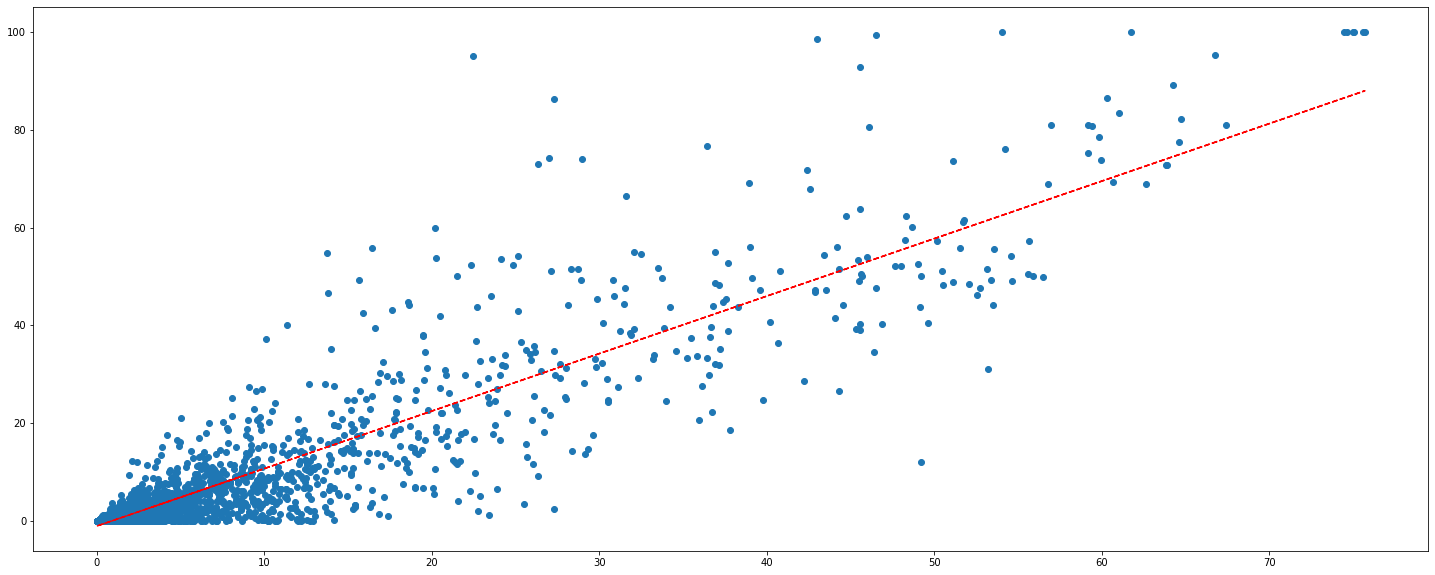

2.5560112861742557

In [446]:
df_f=pd.DataFrame()
df_f['y2']=rf_model_loaded.predict(X)
df_f['y']=y.values
x = df_f['y2']
y = df_f['y']

from sklearn.metrics import mean_absolute_error
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()
mean_absolute_error(x, y)

In [ ]:
## XGboost 

In [447]:
# create an xgboost regression model
xg = XGBRegressor(eta=0.004,
                gamma=0.1,
                learning_rate= 0.03,
                max_depth= 8,
                min_child_weight=3,
                alpha= 20,
                n_estimators=50,
                subsample=0.7,
                colsample_bytree=0.7)

xg_fitted = xg.fit(X, y)

file_name = "models/saved_models/trained_regr_xg.sav"
path = os.path.join(wor_dir, file_name)
pickle.dump(xg_fitted, open(path, "wb"))  


C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_27196/573272359.py:16: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-typhoon-model\\models\\saved_models\\trained_regr_xg.sav'>
  pickle.dump(xg_fitted, open(path, "wb"))


### load model 

In [448]:

# load
xgb_model_loaded = pickle.load(open(path, "rb"))

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_27196/3317275933.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='C:\\Users\\ATeklesadik\\OneDrive - Rode Kruis\\Documents\\documents\\Typhoon-Impact-based-forecasting-model\\IBF-typhoon-model\\models\\saved_models\\trained_regr_xg.sav'>
  xgb_model_loaded = pickle.load(open(path, "rb"))


C:\Users\ATeklesadik\Miniconda3\envs\geo_env\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


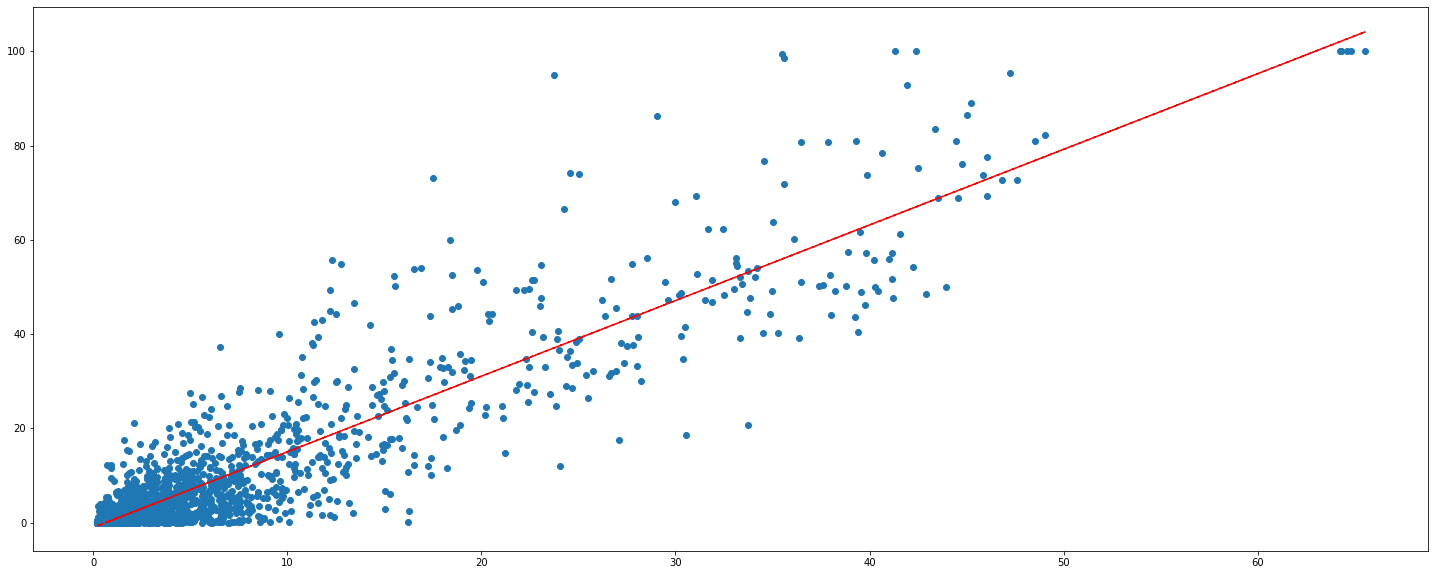

3.018205672812931

In [449]:
df_f=pd.DataFrame()
df_f['y2']=xgb_model_loaded.predict(X)
df_f['y']=y.values
x = df_f['y2']
y = df_f['y']

from sklearn.metrics import mean_absolute_error
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()
mean_absolute_error(x, y)

### Extra information on model parameter Tunning 

<AxesSubplot:>

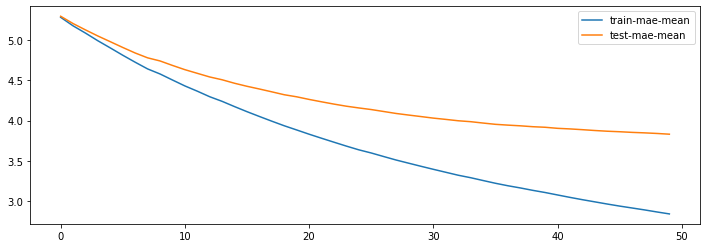

In [410]:
# fit a final xgboost model on the housing dataset and make a prediction
from numpy import asarray
from pandas import read_csv
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import numpy

        
data_dmatrix = xgb.DMatrix(data=X,label=y)



cv_results = xgb.cv(dtrain=data_dmatrix,
                    params=params,
                    nfold=5,
                    num_boost_round=50,
                    #early_stopping_rounds=10,
                    metrics="mae",
                    as_pandas=True,
                    seed=123)

 
cv_results['id']=cv_results.index
df=cv_results.filter(['train-mae-mean','test-mae-mean'])
fig, axs = plt.subplots(figsize=(12, 4))

df.plot.line(ax=axs)

In [411]:
df

train-mae-mean  test-mae-mean
0         5.279998       5.292797
1         5.173980       5.202274
2         5.084126       5.123594
3         4.988893       5.048012
4         4.900338       4.977403
5         4.809921       4.906150
6         4.723523       4.837747
7         4.640562       4.777812
8         4.578064       4.739257
9         4.503392       4.683845
10        4.429930       4.631341
11        4.364936       4.586004
12        4.296104       4.540831
13        4.238832       4.506057
14        4.173817       4.462848
15        4.111148       4.425447
16        4.051568       4.391784
17        3.993165       4.356655
18        3.936553       4.320778
19        3.884589       4.295186
20        3.832112       4.262831
21        3.782109       4.233245
22        3.733131       4.204892
23        3.684723       4.178835
24        3.638702       4.157296
25        3.599566       4.137387
26        3.555682       4.113289
27        3.512479       4.088927
28        3.473589       4.069352
29        3.434982       4.050592
30        3.397318       4.031289
31        3.360751       4.015506
32        3.324119       3.998579
33        3.293465       3.987153
34        3.258642       3.970264
35        3.224422       3.954361
36        3.193822       3.944536
37        3.166649       3.935976
38        3.136932       3.924938
39        3.109941       3.917915
40        3.079642       3.904791
41        3.049632       3.897498
42        3.021132       3.888090
43        2.994289       3.877867
44        2.967311       3.868974
45        2.941785       3.862609
46        2.918316       3.854672
47        2.894665       3.848679
48        2.869123       3.841335
49        2.844954       3.832124

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

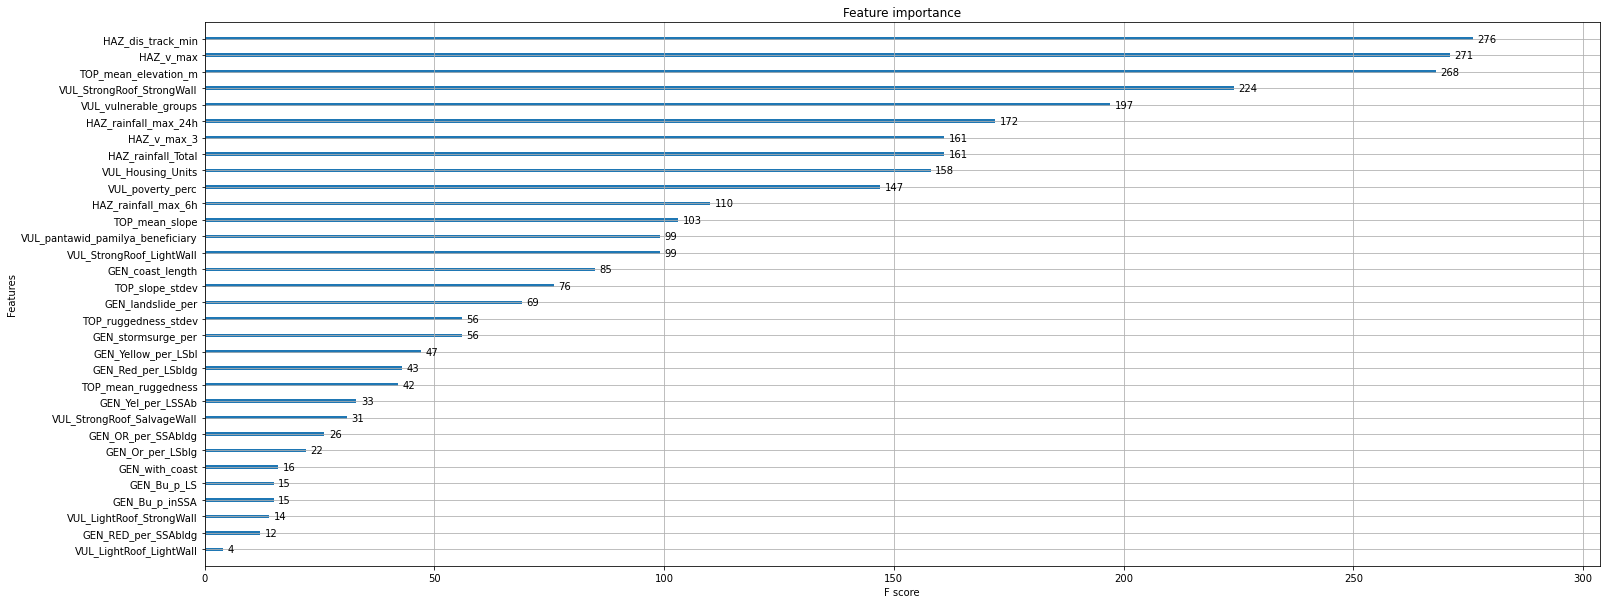

In [409]:
xgb.plot_importance(model_xgb)
#plt.rcParams['figure.figsize'] = [25, 10]
#plt.show()